### Analyze and Predicting Sun Spots Data using CNN, RNN and DNN

In [1]:
## import libraries

import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
## set file name
data = 'Sunspots.csv'

In [3]:
## read data using csv

count = 0
with open(data, newline='') as csvfile:
    file_reader = csv.reader(csvfile)

# read first few lines and check

    for row in file_reader:
        print(row)
        if count >= 5:
            break
        else:
            count+=1

['', 'Date', 'Monthly Mean Total Sunspot Number']
['0', '1749-01-31', '96.7']
['1', '1749-02-28', '104.3']
['2', '1749-03-31', '116.7']
['3', '1749-04-30', '92.8']
['4', '1749-05-31', '141.7']


### Store the data for analysis and prediction
- we need to get rid of the first row, as it contains only the header info
- We will need only the first column i.e. the time series in monthly number and
- Monthly Mean Total Sunspot Number
- All data are in string format, so will need to convert accordingly

In [4]:
data_series = []
time_series = []

with open(data, newline='') as csvfile:
    file_reader = csv.reader(csvfile)
    
    ## skip the first line
    next(file_reader)

    # append the data
    for row in file_reader:
        time_series.append(int(row[0]))   # storing the time series
        data_series.append(float(row[2])) # storing the sunspot number

# convert the data into numpy arrays
data_series = np.array(data_series)
time_series = np.array(time_series)

# print the shape
print(time_series.shape)
print(data_series.shape)

(3235,)
(3235,)


### utility function to plot the data

In [5]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

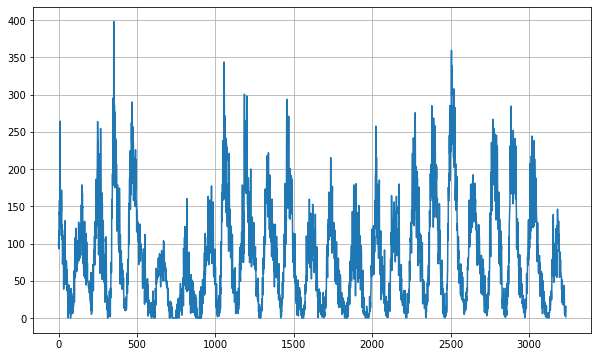

In [7]:
## plot and check

plot_series(time_series, data_series)

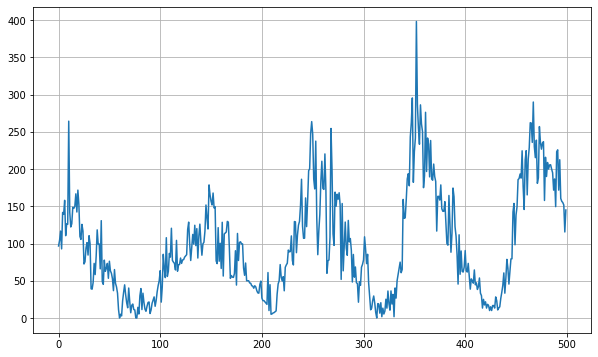

In [8]:
# zoom in and check
plot_series(time_series, data_series, start=0, end=500)

- We can see that around 130-140 units of timesteps (i.e. months) constitutes a full cycle
- that means, around 11 - 12 years
- It is also not very much consistent through out the cycles, but it is forming a general pattern 

### Split the data

In [9]:
split_time = 3000

train_series = data_series[:split_time]
train_time = time_series[:split_time]

valid_series = data_series[split_time:]
valid_time = time_series[split_time:]

# check the shape
print(train_series.shape)
print(valid_series.shape)

(3000,)
(235,)


### generate windowed dataset

In [10]:
# function to generate window dataset

def generate_window_dataset(series, buffer_size, batch_size, window_size):
    
    # generate dataset
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # window
    dataset = dataset.window(size = window_size + 1, shift=1, drop_remainder=True)
    
    # flatten
    dataset = dataset.flat_map(lambda window:window.batch(window_size + 1))
    
    # create features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    # shuffle
    dataset = dataset.shuffle(buffer_size=buffer_size)
    
    # batch
    dataset = dataset.batch(batch_size=batch_size).prefetch(1)
    
    return dataset
    

In [11]:
## set param values

batch_size = 32
window_size = 30 # keeping around 30 months for window size, we will start with this
buffer_size = 1000

In [12]:
## generate training data

train_data = generate_window_dataset(train_series, buffer_size, batch_size, window_size)

In [13]:
# check the train data

for data in train_data.take(1):
    print('feature shape : {}'.format(data[0].shape))
    print('label shape :{}'.format(data[1].shape))

feature shape : (32, 30)
label shape :(32,)


### Build Model

In [16]:
# clear the session data
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    
    # convd layers
    tf.keras.layers.Conv1D(64, 3,
                           padding='causal',
                           strides = 1,
                           activation='relu',
                           input_shape= ([window_size, 1])),
    
    # LSTM layers
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64),
    
    # dense layers
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(10, activation ='relu'),
    tf.keras.layers.Dense(1),
    
    # add a lambda layer to format the output
    tf.keras.layers.Lambda(lambda x: x* 400.0)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

In [17]:
## store the initial weights

init_weights = model.get_weights()

In [18]:
## set up the learning rate parameter

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-8 * 10 ** (epoch/window_size))

# compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),
             loss=tf.keras.losses.Huber(),
             metrics = ['mae'])

# fit the model
model.fit(train_data, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 7s 36ms/step - loss: 87.3198 - mae: 87.8194 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 3s 27ms/step - loss: 64.2869 - mae: 64.7848 - lr: 1.0798e-08
Epoch 3/100
93/93 [==============================] - 2s 24ms/step - loss: 49.9704 - mae: 50.4651 - lr: 1.1659e-08
Epoch 4/100
93/93 [==============================] - 2s 24ms/step - loss: 44.7047 - mae: 45.2006 - lr: 1.2589e-08
Epoch 5/100
93/93 [==============================] - 2s 24ms/step - loss: 42.5324 - mae: 43.0294 - lr: 1.3594e-08
Epoch 6/100
93/93 [==============================] - 2s 25ms/step - loss: 41.0040 - mae: 41.5010 - lr: 1.4678e-08
Epoch 7/100
93/93 [==============================] - 2s 24ms/step - loss: 39.7123 - mae: 40.2091 - lr: 1.5849e-08
Epoch 8/100
93/93 [==============================] - 2s 24ms/step - loss: 38.4695 - mae: 38.9658 - lr: 1.7113e-08
Epoch 9/100
93/93 [==============================] - 2s 24ms/step - loss: 37.0413 - mae:

93/93 [==============================] - 3s 28ms/step - loss: 18.6866 - mae: 19.1794 - lr: 2.3263e-06
Epoch 73/100
93/93 [==============================] - 3s 28ms/step - loss: 18.7472 - mae: 19.2389 - lr: 2.5119e-06
Epoch 74/100
93/93 [==============================] - 3s 28ms/step - loss: 18.8719 - mae: 19.3644 - lr: 2.7123e-06
Epoch 75/100
93/93 [==============================] - 3s 29ms/step - loss: 18.7879 - mae: 19.2806 - lr: 2.9286e-06
Epoch 76/100
93/93 [==============================] - 3s 28ms/step - loss: 19.5047 - mae: 19.9979 - lr: 3.1623e-06
Epoch 77/100
93/93 [==============================] - 3s 28ms/step - loss: 18.8791 - mae: 19.3703 - lr: 3.4145e-06
Epoch 78/100
93/93 [==============================] - 3s 28ms/step - loss: 19.0044 - mae: 19.4977 - lr: 3.6869e-06
Epoch 79/100
93/93 [==============================] - 3s 29ms/step - loss: 19.7901 - mae: 20.2836 - lr: 3.9811e-06
Epoch 80/100
93/93 [==============================] - 3s 28ms/step - loss: 20.1011 - mae: 20.

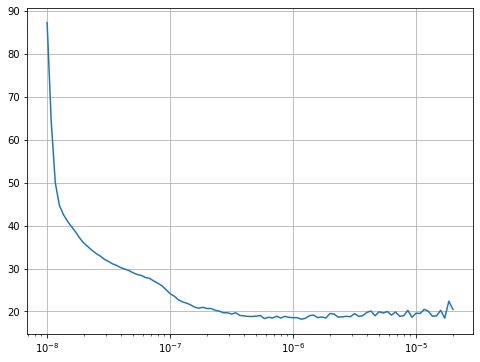

In [19]:
## plot the loss against the learning rate

metrics = pd.DataFrame(model.history.history)
metrics

plt.figure(figsize=(8,6))
plt.semilogx(metrics['lr'], metrics['loss'])
plt.grid(True)
plt.show()

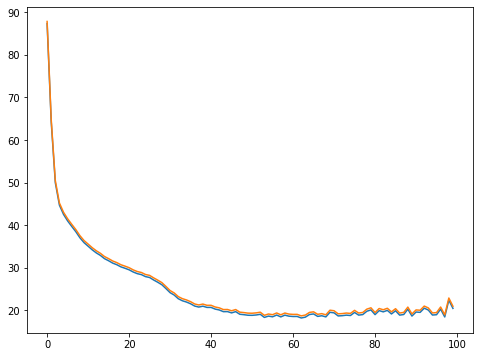

In [20]:
## plot the loss and the mae as per epoch

epoch_range = range(100)
plt.figure(figsize=(8,6))
plt.plot(epoch_range, metrics['loss'])
plt.plot(epoch_range, metrics['mae'])
plt.show()

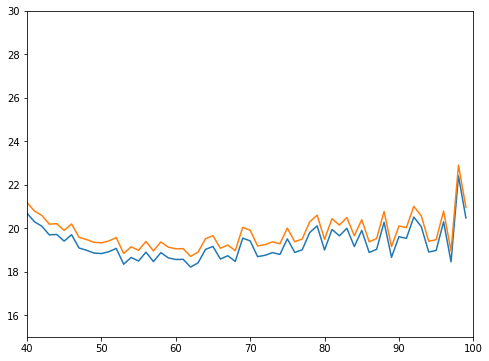

In [22]:
## plot the loss and the mae as per epoch

epoch_range = range(100)
plt.figure(figsize=(8,6))
plt.plot(epoch_range, metrics['loss'])
plt.plot(epoch_range, metrics['mae'])
plt.axis([40,100,15,30])
plt.show()

In [23]:
## for retrain set the intial model weights again

model.set_weights(init_weights)

In [24]:
## Re-train the model again

# clear the session data
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    
    # convd layers
    tf.keras.layers.Conv1D(64, 3,
                           padding='causal',
                           strides = 1,
                           activation='relu',
                           input_shape= ([window_size, 1])),
    
    # LSTM layers
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64),
    
    # dense layers
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(10, activation ='relu'),
    tf.keras.layers.Dense(1),
    
    # add a lambda layer to format the output
    tf.keras.layers.Lambda(lambda x: x* 400.0)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

In [25]:
## set up the learning rate parameter

learning_rate = 4e-7

# compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
             loss=tf.keras.losses.Huber(),
             metrics = ['mae'])

# fit the model
model.fit(train_data, epochs=100)

Epoch 1/100
93/93 [==============================] - 6s 24ms/step - loss: 54.8077 - mae: 55.3052
Epoch 2/100
93/93 [==============================] - 2s 24ms/step - loss: 30.6599 - mae: 31.1533
Epoch 3/100
93/93 [==============================] - 3s 26ms/step - loss: 25.9577 - mae: 26.4540
Epoch 4/100
93/93 [==============================] - 3s 29ms/step - loss: 23.0850 - mae: 23.5790
Epoch 5/100
93/93 [==============================] - 3s 26ms/step - loss: 21.7282 - mae: 22.2221
Epoch 6/100
93/93 [==============================] - 2s 24ms/step - loss: 21.0004 - mae: 21.4948
Epoch 7/100
93/93 [==============================] - 3s 27ms/step - loss: 20.4237 - mae: 20.9184
Epoch 8/100
93/93 [==============================] - 3s 27ms/step - loss: 19.9303 - mae: 20.4238
Epoch 9/100
93/93 [==============================] - 3s 28ms/step - loss: 19.5180 - mae: 20.0135
Epoch 10/100
93/93 [==============================] - 2s 24ms/step - loss: 19.4788 - mae: 19.9725
Epoch 11/100
93/93 [=========

93/93 [==============================] - 3s 27ms/step - loss: 17.3890 - mae: 17.8805
Epoch 85/100
93/93 [==============================] - 3s 27ms/step - loss: 17.2987 - mae: 17.7895
Epoch 86/100
93/93 [==============================] - 3s 27ms/step - loss: 17.4562 - mae: 17.9481
Epoch 87/100
93/93 [==============================] - 3s 28ms/step - loss: 17.4537 - mae: 17.9461
Epoch 88/100
93/93 [==============================] - 3s 28ms/step - loss: 17.6629 - mae: 18.1562
Epoch 89/100
93/93 [==============================] - 3s 28ms/step - loss: 17.7985 - mae: 18.2903
Epoch 90/100
93/93 [==============================] - 3s 30ms/step - loss: 17.1460 - mae: 17.6377
Epoch 91/100
93/93 [==============================] - 3s 31ms/step - loss: 17.4041 - mae: 17.8959
Epoch 92/100
93/93 [==============================] - 3s 29ms/step - loss: 17.2629 - mae: 17.7543
Epoch 93/100
93/93 [==============================] - 3s 29ms/step - loss: 17.0534 - mae: 17.5448
Epoch 94/100
93/93 [=============

### Validate using the validation data

In [26]:
## function to generate prediction

def get_predictions(model, series, batch_size, window_size):
    
    # generate dataset
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # window
    dataset = dataset.window(size = window_size, shift=1, drop_remainder=True)
    
    # flatten
    dataset = dataset.flat_map(lambda window:window.batch(window_size))

    # batch
    dataset = dataset.batch(batch_size=batch_size).prefetch(1)
    
    # predict
    predictions = model.predict(dataset)
    
    return predictions

In [27]:
## set up and create validation data for prediction

forecast_data = data_series[split_time - window_size : -1]

forecasts = get_predictions(model, forecast_data, batch_size, window_size)

print(forecasts.shape)

8/8 [==============================] - 1s 14ms/step
(235, 1)


In [28]:
results = forecasts.squeeze()

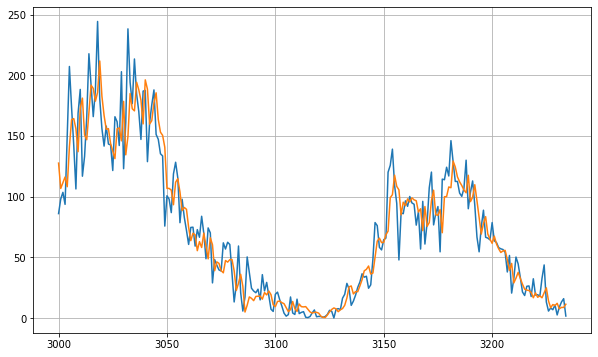

In [29]:
## plot

plot_series(valid_time, (valid_series, results))

In [30]:
## get metrics

print('Mean Squared Error: {}'.format(tf.keras.metrics.mean_squared_error(valid_series, results).numpy()))
print('Mean Absolute Error: {}'.format(tf.keras.metrics.mean_absolute_error(valid_series, results).numpy()))

Mean Squared Error: 424.0918884277344
Mean Absolute Error: 14.247867584228516


In [31]:
data_series.mean()

82.48108191653786

### Another way to tune the learning rate

At some point, the static learning rate we set might no longer be the optimal one when the model has been learning for some time. So, we may want to decrease it some more to see better improvements. One way to do that is to have our training loop gradually decay the learning rate per epoch. We can pass in a lambda function similar like the one we did for the learning rate scheduler earlier, or use ExponentialDecay(). This is a built in scheduler from the Keras API. This decays the learning rate defined by this function:

def decayed_learning_rate(step):
  return initial_learning_rate * decay_rate ^ (step / decay_steps)

In [33]:
# Set the initial learning rate
initial_learning_rate=4e-7

# Define the scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True)

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_data,epochs=40)

Epoch 1/40
93/93 [==============================] - 6s 24ms/step - loss: 17.0660 - mae: 17.5572
Epoch 2/40
93/93 [==============================] - 3s 26ms/step - loss: 17.2885 - mae: 17.7797
Epoch 3/40
93/93 [==============================] - 3s 29ms/step - loss: 17.1765 - mae: 17.6673
Epoch 4/40
93/93 [==============================] - 3s 26ms/step - loss: 17.3235 - mae: 17.8131
Epoch 5/40
93/93 [==============================] - 3s 27ms/step - loss: 17.1107 - mae: 17.6016
Epoch 6/40
93/93 [==============================] - 3s 29ms/step - loss: 17.0373 - mae: 17.5280
Epoch 7/40
93/93 [==============================] - 3s 25ms/step - loss: 17.2716 - mae: 17.7618
Epoch 8/40
93/93 [==============================] - 3s 26ms/step - loss: 17.1029 - mae: 17.5947
Epoch 9/40
93/93 [==============================] - 3s 25ms/step - loss: 17.1648 - mae: 17.6564
Epoch 10/40
93/93 [==============================] - 3s 26ms/step - loss: 17.0179 - mae: 17.5082
Epoch 11/40
93/93 [====================

8/8 [==============================] - 1s 14ms/step
(235, 1)


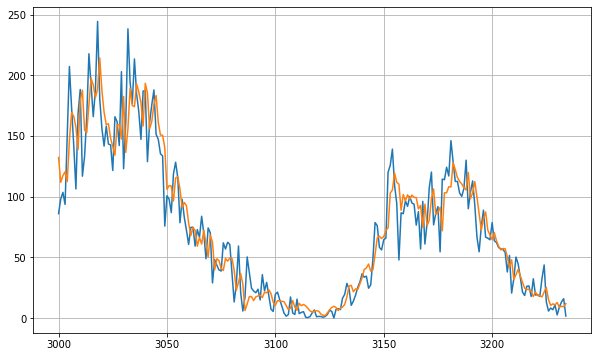

In [34]:
## set up and create validation data for prediction

forecast_data = data_series[split_time - window_size : -1]

forecasts = get_predictions(model, forecast_data, batch_size, window_size)

print(forecasts.shape)

results = forecasts.squeeze()

## plot
plot_series(valid_time, (valid_series, results))

In [35]:
## get metrics

print('Mean Squared Error: {}'.format(tf.keras.metrics.mean_squared_error(valid_series, results).numpy()))
print('Mean Absolute Error: {}'.format(tf.keras.metrics.mean_absolute_error(valid_series, results).numpy()))

Mean Squared Error: 419.9393005371094
Mean Absolute Error: 14.304119110107422
